In [1]:
!pip install fastai2
!pip install kornia

     |████████████████████████████████| 179 kB 4.8 MB/s 
     |████████████████████████████████| 142 kB 4.8 MB/s 
     |████████████████████████████████| 2.1 MB 51.6 MB/s 
ERROR: catalyst 20.2.4 has requirement Pillow<7, but you'll have pillow 7.0.0 which is incompatible.
  Attempting uninstall: pillow
    Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [2]:
import numpy as np
import pandas as pd
import pydicom
from matplotlib import pyplot as plt
from path import Path
import glob
from PIL import Image
from fastai2.basics import *
from fastai2.medical.imaging import *

In [3]:
root = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'

In [4]:
trn_path  = root + 'stage_2_train'
test_path = root + 'stage_2_test'

In [5]:
trn_files = glob.glob(trn_path + '/*.dcm')
test_files = glob.glob(test_path+ '/*.dcm')

In [6]:
len(trn_files), len(test_files)

(752803, 121232)

A dicom file contains a lot of things. We can check them using the following command

In [7]:
img = pydicom.dcmread(trn_files[0])
img

(0008, 0018) SOP Instance UID                    UI: ID_b83c56d9b
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_71293fa9'
(0020, 000d) Study Instance UID                  UI: ID_63b6d5bfda
(0020, 000e) Series Instance UID                 UI: ID_4a7d4a953a
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: [-125.000000, -108.900002, 28.745001]
(0020, 0037) Image Orientation (Patient)         DS: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: [0.488281, 0.488281]
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                        

In [8]:
trn_imgs = [Path(x) for x in trn_files]

In [9]:
# trn_imgs = [pydicom.dcmread(img) for img in trn_files[:10]]
df_trn = pd.DataFrame.from_dicoms(trn_imgs[:10], px_summ=True)
df_trn.head()

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1
0,ID_b83c56d9b,CT,ID_71293fa9,ID_63b6d5bfda,ID_4a7d4a953a,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-2000,2895,-34.158745,1159.045029,0.089848,NaN,NaN,NaN,NaN
1,ID_ce2c5de36,CT,ID_aca1438c,ID_9cf114d35c,ID_d2ea2cfcbb,,-125.0,1.0,1,MONOCHROME2,...,0.488281,0,4000,367.852451,509.428702,0.087467,1.0,36.0,1.0,80.0
2,ID_a17def68d,CT,ID_e5508c5e,ID_d77be38921,ID_626dc2b8ec,,-125.0,1.0,1,MONOCHROME2,...,0.488281,-1024,2370,-10.169102,790.043831,0.016087,NaN,NaN,NaN,NaN
3,ID_27d79621e,CT,ID_1886703c,ID_e3c88ec7d3,ID_d0825efcd8,,-107.0,1.0,1,MONOCHROME2,...,0.488281,0,2362,412.332020,588.403749,0.136658,1.0,40.0,1.0,80.0
4,ID_52ea72f4e,CT,ID_2639bab6,ID_5d626bac2c,ID_996b73d52f,,-117.5,1.0,1,MONOCHROME2,...,0.451172,5,2603,545.967014,586.343059,0.236221,1.0,36.0,1.0,80.0


In [10]:
def show_batch(x, nrows = 5, ncols = 5):
    """
    Read a list of pydicom images, and display them
    """
    fig=plt.figure(figsize=(9, 9))
    columns = rows = 3
    for i in range(1, columns*rows +1):
        ds = x[i].dcmread()
        fig.add_subplot(rows, columns, i)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        fig.add_subplot

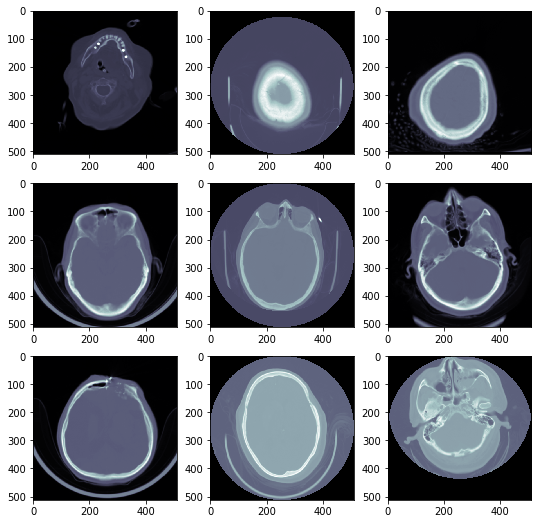

In [11]:
show_batch(trn_imgs[0:10])

We see that some of the images are not of the brain but of teeth. Some other images are mostly black because they are images of above or below the brain and hence contain no useful information at all. We will remove all such images.

In [12]:
root2 = Path('../input/rsna-hemorrhage-jpg/meta/meta/')

In [13]:
df = pd.read_feather(root2 / 'comb.fth')
df.head()

,BitsAllocated,BitsStored,Columns,HighBit,ImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,...,img_mean,img_min,img_pct_window,img_std,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,16,16,512,15,1.0,0.0,0.0,0.0,0.927184,-0.374607,...,35.112926,-2000,0.164139,1166.720843,0,0,0,0,0,0
1,16,12,512,11,1.0,0.0,0.0,0.0,1.000000,0.000000,...,234.549896,0,0.076015,392.132243,0,0,0,0,0,0
2,16,16,512,15,1.0,0.0,0.0,0.0,1.000000,0.000000,...,482.248981,0,0.241489,571.235614,1,0,1,1,0,0
3,16,16,512,15,1.0,0.0,0.0,0.0,0.927184,-0.374607,...,106.237759,-2000,0.242466,1253.462451,1,0,1,0,0,0
4,16,12,512,11,1.0,0.0,0.0,0.0,1.000000,0.000000,...,536.799244,9,0.345436,568.654045,0,0,0,0,0,0


In [14]:
df.shape

(674257, 48)

There is a column in the data frame img_pct_window which indicates % of pixels in the brain window. We will use this column to determine which images to discard

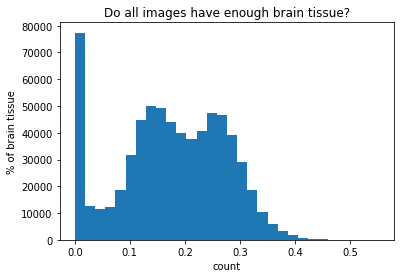

In [15]:
plt.hist(df['img_pct_window'], 30)
plt.xlabel('count')
plt.ylabel('% of brain tissue')
plt.title('Do all images have enough brain tissue?');

Let's check these discarded images

In [16]:
discarded = df[df['img_pct_window'] < 0.2]

In [17]:
dimgs = list(discarded['SOPInstanceUID'].values)
len(dimgs)

386114

In [18]:
dimgs = [Path(root + 'stage_2_train/'+ d + '.dcm') for d in dimgs]
dimgs[0]

Path('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_352e89f1c.dcm')

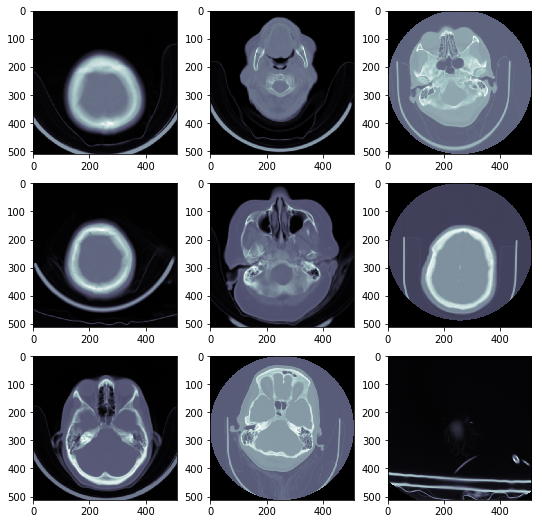

In [19]:
show_batch(dimgs[10:20])

This looks good. We can remove these images. There are also some images with incorrect RescaleIntercept

In [20]:
ids = df[df['RescaleIntercept'] > -100]['SOPInstanceUID']

In [21]:
ids

131       ID_310ca507a
167       ID_0c77ccf54
387       ID_c65277971
475       ID_e0524fdcc
503       ID_4d1524921
              ...     
673907    ID_93f027d4a
673930    ID_7541fb415
673996    ID_b2aa5b16d
674054    ID_20e69d5c9
674087    ID_b80939794
Name: SOPInstanceUID, Length: 5326, dtype: object

In [22]:
intcpts = [Path(root + 'stage_2_train/'+ d + '.dcm').dcmread() for d in ids[:10]]

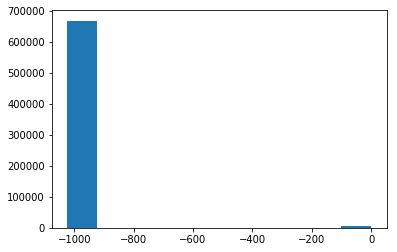

In [23]:
plt.hist(df['RescaleIntercept']);

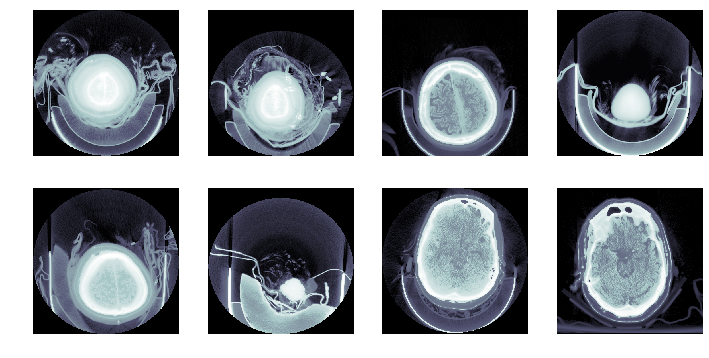

In [24]:
_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): intcpts[i].show(ax=ax)

Rescale intercept usually has mode 0. But in our data it has -1000. This can be some kind of error during data creation. Maybe a use of signed data instead of unsigned. Hence we add 1000 to this column

In [25]:
df['RescaleIntercept'] += 1000

We then crop them to size 256 * 256 and save them in brain window

(256, 256)


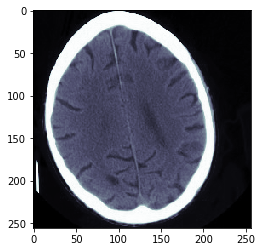

In [26]:
im = np.array(Image.open('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/ID_2dfa9f6f8.jpg').convert('L'))
print(im.shape)
plt.imshow(im, cmap=plt.cm.bone);